# Perkenalan

Name        : Sigit Pramana

Dataset     : sample_dataset_timeseries_noarea.csv berisi data penjualan berbagai produk dari Norea selama periode tertentu

Objective   : Membuat model untuk forecasting quantity/penjualan produk selama 5 minggu mendatang pada dataset yang tersedia

# Import Libraries

In [1]:
# menambhakan libraries

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
warnings.filterwarnings('ignore')

# Data Loading

In [2]:
# load data
data = pd.read_csv(r"C:\Users\MyBook Z Series\Documents\Hacktiv8\Final Projects\sample_dataset_timeseries_noarea.csv")

In [3]:
# menampilkan 5 baris awal data
data.head(5)

,week_number,week_start_date,week_end_date,product_item,quantity
0,2021-52,2021-12-27,2022-01-02,0073377087c7ddace313ff829cd7b0b3,41
1,2021-52,2021-12-27,2022-01-02,012d2bb142b2d5e57330acbfd8e9ac52,430
2,2021-52,2021-12-27,2022-01-02,0192926e33d1153b63511a5b83eca843,4
3,2021-52,2021-12-27,2022-01-02,019502f6d13e383caa9b9673bf1302f8,148
4,2021-52,2021-12-27,2022-01-02,01e7ca6d4e21badc1d4225b6b2c7bd9e,119


Data penjualan dimulai dari 2021-12-27

In [4]:
# menampilkan 5 baris akhir data
data.tail(5)

,week_number,week_start_date,week_end_date,product_item,quantity
102728,2023-14,2023-04-03,2023-04-09,ff3890faa80ff425ae906e27bbc50bc6,907
102729,2023-14,2023-04-03,2023-04-09,ff4b0f3b9c78c91510a4e3920fbc5090,81
102730,2023-14,2023-04-03,2023-04-09,ff9d05a4d6f922b3ab1653f58165b8ce,16
102731,2023-14,2023-04-03,2023-04-09,ffbd6f1d884056a4f622d54ae79e5a14,42920
102732,2023-14,2023-04-03,2023-04-09,fff18f7c705e729746515e2053dee64b,53


Berakhir pada 2023-04-09

# Exploratory Data Analysis

In [5]:
# check product item

print('Jumlah Semua Produk : ', data['product_item'].nunique())

Jumlah Semua Produk :  2309


Terdapat 2309 produk pada dataset, jadi disini kita akan coba membuat forecating untuk semua produk tersebut

In [6]:
# check week number

print('Jumlah Minggu Dalam Data : ',data['week_number'].nunique())

Jumlah Minggu Dalam Data :  67


Dari jumlah minggu pada kolom week number, disini saya mendapati bahwa data penjualan merupakan data timeseries mingguan, jadi quantity berisi total data penjualan sebuah produk selama 1 minggu. Karena terdapat banyak produk, saya merasa tidak yakin bahwa semua produk mengalami penjualan pada setiap minggunya, maka disini saya akan coba mengecek produk apa sajakah yang konsisten ada penjualan pada setiap minggunya. Hal ini saya lakukan untuk menjaga data agar tetap asli untuk digunakan sebagai pelatihan model, karena kalau banyak produk yang tidak konsisten ada penjualan tiap minggunnya selama preriode penjualan, ini sama saja missing value, dimana pada pelatihan model tidak boleh ada missing value, sementara itu untuk mengisi missing value tersebut kita harus memanipulasi data, yang harusnya tidak ada penjualan dibuatkan data seakan akan ada penjualan, maka untuk menjaga agar data tetap asli saya tidak memakai data yang ada missing valuenya.

In [7]:
# mengubah week_end_date ke dalam datetime
data['week_end_date'] = pd.to_datetime(data['week_end_date'])

# menambahkan kolom baru
data['weeks'] = (data['week_end_date'] - datetime.datetime(2022, 1 , 2)).dt.days // 7 + 1

# melakukan filter pada data untuk mendapatkan product_item yang memiliki weeks penuh samapi 67
full_week_numbers = data.groupby('product_item').filter(lambda x: x['weeks'].nunique() == 67)['product_item'].unique()

# melakukan filter pada data untuk mendapatkan data dengan weeks penuh dari 1 sampai 67
filtered_data = data[(data['weeks'] >= 1) & (data['weeks'] <= 67) & (data['product_item'].isin(full_week_numbers))]

# menampilkan jumlah produk yang setiap minggu ada penjualan sampai minggu terakhir
print('Jumlah Produk yang Konsisten Tiap Minggunya Ada Penjualan = ',filtered_data['product_item'].nunique())

Jumlah Produk yang Konsisten Tiap Minggunya Ada Penjualan =  368


Dari 2309 produk yang terjual selama periode 2021-12-27 samapai dengan 2023-04-09 hanya 368 produk saja yang setiap minggunnya konsisten ada penjualan, maka disini saya akan mencoba membuat model untuk forecast untuk dengan data latih 368 produk itu, karena 368 produk itu mempunyai data penjualan yang lengkap selama 67 minggu, dan data yang masih asli, tidak ada manipulasi

# Membuat Model Forecasting

Dalam proses ini saya mencoba membuat model untuk forecast dengan hasil semua produk yang mempunyai data penuh, tidak ada missing value, menggunakan model LSTM yaitu "Long Short-Term Memory" yang merupakan salah satu jenis arsitektur di Artificial Neural Network.

In [8]:
# pivot table
data = filtered_data.pivot_table(index=['week_start_date', 'week_end_date'], columns='product_item', values='quantity')

# memuat seluruh produk
n_products = len(data.columns)

# normalize data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# menyiapkan data untuk LSTM
n_input = 12
X, y = [], []
for i in range(len(data_scaled)-n_input):
    X.append(data_scaled[i:i+n_input])
    y.append(data_scaled[i+n_input])
X_train, X_test = np.array(X[:int(len(X)*0.8)]), np.array(X[int(len(X)*0.8):])
y_train, y_test = np.array(y[:int(len(y)*0.8)]), np.array(y[int(len(y)*0.8):])

# mendefiniskan model LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_input, n_products)))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(n_products))
model.compile(optimizer='adam', loss='mse')

# melatih model
model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), verbose=2)

Epoch 1/100
2/2 - 2s - loss: 0.3087 - val_loss: 0.1665 - 2s/epoch - 799ms/step
Epoch 2/100
2/2 - 0s - loss: 0.2651 - val_loss: 0.1580 - 40ms/epoch - 20ms/step
Epoch 3/100
2/2 - 0s - loss: 0.2513 - val_loss: 0.1487 - 40ms/epoch - 20ms/step
Epoch 4/100
2/2 - 0s - loss: 0.2373 - val_loss: 0.1399 - 38ms/epoch - 19ms/step
Epoch 5/100
2/2 - 0s - loss: 0.2192 - val_loss: 0.1269 - 40ms/epoch - 20ms/step
Epoch 6/100
2/2 - 0s - loss: 0.2048 - val_loss: 0.1168 - 40ms/epoch - 20ms/step
Epoch 7/100
2/2 - 0s - loss: 0.1831 - val_loss: 0.1040 - 43ms/epoch - 21ms/step
Epoch 8/100
2/2 - 0s - loss: 0.1648 - val_loss: 0.0923 - 40ms/epoch - 20ms/step
Epoch 9/100
2/2 - 0s - loss: 0.1473 - val_loss: 0.0815 - 43ms/epoch - 22ms/step
Epoch 10/100
2/2 - 0s - loss: 0.1283 - val_loss: 0.0704 - 41ms/epoch - 21ms/step
Epoch 11/100
2/2 - 0s - loss: 0.1119 - val_loss: 0.0629 - 41ms/epoch - 20ms/step
Epoch 12/100
2/2 - 0s - loss: 0.1046 - val_loss: 0.0561 - 41ms/epoch - 20ms/step
Epoch 13/100
2/2 - 0s - loss: 0.0890 -

In [9]:
# membuat prediksi dalam data test
pred = model.predict(X_test)
pred_inv = scaler.inverse_transform(pred)

# membuat datafrme hasil prediksi data test
pred_df = pd.DataFrame(pred_inv, columns=data.columns)
pred_df.index = data.index[-len(X_test):]

pred_df

1/1 [==============================] - 0s 185ms/step


,product_item,0073377087c7ddace313ff829cd7b0b3,012d2bb142b2d5e57330acbfd8e9ac52,0192926e33d1153b63511a5b83eca843,019502f6d13e383caa9b9673bf1302f8,01e7ca6d4e21badc1d4225b6b2c7bd9e,043e6d02d98b44c40645c8a22812fe88,0512efdcc99fa4d57c42cd2cf6c73633,05262da388ab82c51c48c9535bc8b121,058cc2cecb91d10e901a597e67532619,061bbbc356dfea798f6fea783a9513b1,...,f8f2fbcc7e3ff8d333b2f970e1fed859,f917a67b1901e24541ecd68341dbbc99,fb34438dafbc1708879748399c3bcc94,fba8e7dfadea805ae8251eab20169792,fda16dfcd861b1909968109c94ccd4e7,fe2e9633313ef193495cc10e96a11ad0,fe88080dd6a4387f1035c908d3ec26a5,fed98e52dd33638523d6028c19c3a103,ff24eb021c575c9a1dc709c3f8d6631a,ffbd6f1d884056a4f622d54ae79e5a14
week_start_date,week_end_date,,,,,,,,,,,,,,,,,,,,,
2023-01-23,2023-01-29,85.239861,7244.729980,20138.515625,2209.001709,11766.881836,4971.657227,1184.569458,3277.950928,31533.177734,10533.053711,...,2722.678223,2254.124756,3600.673096,10078.521484,4890.998047,1803.443115,4974.764648,27125.421875,597.969849,49895.117188
2023-01-30,2023-02-05,86.812622,7346.025879,20542.841797,2222.967285,11921.114258,5074.569336,1192.535645,3337.479492,31794.419922,10711.115234,...,2750.292480,2290.548096,3650.712646,10328.830078,4999.947266,1835.218872,5006.126953,27472.492188,604.140869,50632.082031
2023-02-06,2023-02-12,86.568069,7294.477539,20449.816406,2219.512695,11843.007812,4991.420410,1193.316650,3323.145996,31666.468750,10649.325195,...,2736.077881,2278.516357,3612.361084,10362.516602,4948.700684,1824.943481,4925.866699,27155.373047,599.187927,49960.058594
2023-02-13,2023-02-19,86.970848,7352.986816,20706.447266,2264.536377,11999.333008,5116.667969,1190.674438,3362.290771,31780.173828,10785.489258,...,2741.578613,2294.594482,3639.501953,10369.656250,5036.619141,1846.798462,4951.792480,27395.396484,603.941284,50481.527344
2023-02-20,2023-02-26,88.665962,7587.763184,21282.031250,2368.658447,12282.218750,5439.826660,1197.374390,3482.600098,32197.820312,10989.559570,...,2777.598877,2360.113525,3718.135254,10876.039062,5266.940918,1905.931030,5001.994141,27987.296875,614.556274,51741.964844
2023-02-27,2023-03-05,88.728210,7418.784180,20595.871094,2313.489014,11995.328125,5173.672852,1187.020264,3431.973145,31700.525391,10723.793945,...,2722.975342,2328.587891,3591.358154,10769.148438,5076.857910,1877.197510,4863.283203,27104.794922,600.754333,50343.265625
2023-03-06,2023-03-12,88.275711,7455.649414,20798.537109,2336.926514,12082.292969,5311.830566,1181.809692,3456.195801,31636.722656,10824.542969,...,2723.226074,2341.375244,3622.066895,10508.863281,5162.927734,1885.654541,4880.068359,27399.466797,604.694458,51063.226562
2023-03-13,2023-03-19,86.367943,7202.570312,20090.433594,2311.446045,11848.753906,5063.356934,1166.877441,3378.600830,31121.625000,10578.971680,...,2665.225098,2280.668457,3497.602539,9963.523438,4933.801758,1838.044678,4738.585938,26641.958984,591.122314,49596.953125
2023-03-20,2023-03-26,83.666222,6977.249023,19553.242188,2286.320312,11601.161133,4850.254395,1146.267578,3270.890625,30427.552734,10354.548828,...,2606.684814,2220.779053,3428.619629,9209.921875,4763.097656,1781.623291,4640.285156,26115.757812,578.773743,48449.113281


In [10]:
# membandingkan hasil prediksi model dalam data test dengan data aktual

filtered_data[filtered_data['product_item']=='0073377087c7ddace313ff829cd7b0b3'].tail(11)

,week_number,week_start_date,week_end_date,product_item,quantity,weeks
86235,2023-04,2023-01-23,2023-01-29,0073377087c7ddace313ff829cd7b0b3,11,57
87740,2023-05,2023-01-30,2023-02-05,0073377087c7ddace313ff829cd7b0b3,5,58
89240,2023-06,2023-02-06,2023-02-12,0073377087c7ddace313ff829cd7b0b3,15,59
90743,2023-07,2023-02-13,2023-02-19,0073377087c7ddace313ff829cd7b0b3,9,60
92252,2023-08,2023-02-20,2023-02-26,0073377087c7ddace313ff829cd7b0b3,7,61
93727,2023-09,2023-02-27,2023-03-05,0073377087c7ddace313ff829cd7b0b3,21,62
95220,2023-10,2023-03-06,2023-03-12,0073377087c7ddace313ff829cd7b0b3,6,63
96738,2023-11,2023-03-13,2023-03-19,0073377087c7ddace313ff829cd7b0b3,22,64
98238,2023-12,2023-03-20,2023-03-26,0073377087c7ddace313ff829cd7b0b3,4,65
99718,2023-13,2023-03-27,2023-04-02,0073377087c7ddace313ff829cd7b0b3,5,66


- Disini saya coba membandingkan prediksi model pada data test dengan data aslinya, dimana untuk produk dengan ID = 0073377087c7ddace313ff829cd7b0b3 pada tanggal 2023-04-09 model memprediksi 98an padahal dalam data aslinya produk hanya terjul 4 pcs, ini sangat eror sekali model yang saya buta, saya sudah mencoba berkali kali mengungah paramter dan menggunakan model lain juga namun hasil prediksinya selalu erornya tinggi, mungkin ini terjadi karena jumlah produk yang terelalu banyak, jadi model kurang bisa belajar, makanya erornya tinggi jika langsung memprediksi seluruh produk yang ada. Ini bisa terjadi juga karena data preprosesing saya yang kurang tepat, karena keterbatasan pengetahuan saya, jadi model underfit, tidak akurat dalam membuat prediksi. Karena pada data test saja hasilnnya sudah kacau, maka saya tidak membuat forecast dengan model tersebut

# Memperbaiki Model

Idealnya untuk membuat forcast, kita perlu breakdown satu persatu untuk setiap produknya, jadi setiap produk dibuatkan model sendiri untuk forecast, karena karakteristik setiap produk berbeda-beda, trendnya beda, seasoanalitas tiap produk juga berbeda-beda. Maka dari itu untuk membuat forecast yang lebih baik, disini saya akan mencoba menggambil beberapa produk saja untuk dibuat forcastnya dalam kurun waktu 5 minggu dari data terakhir

## Produk A

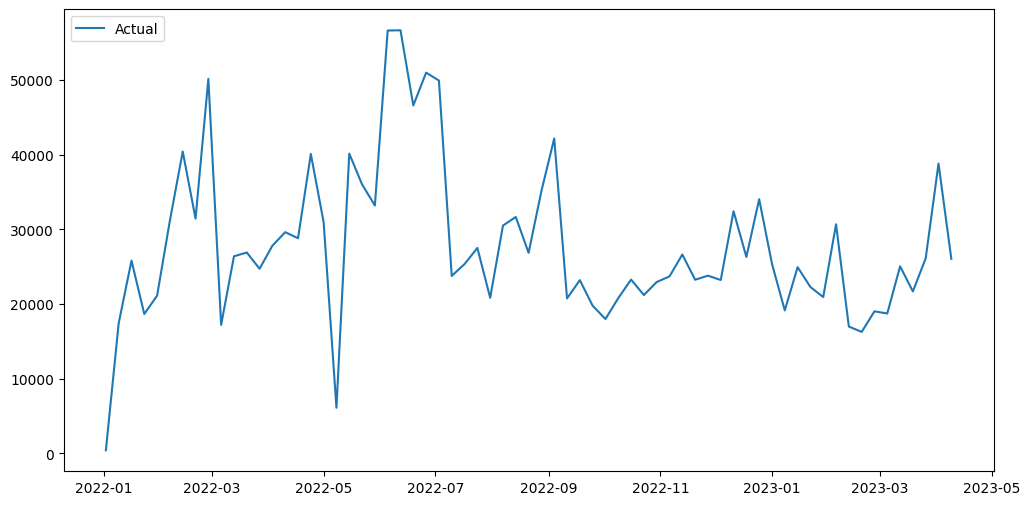

In [11]:
# mengambil salah satu produk pada dataset
df_a1 = filtered_data[filtered_data['product_item']=='a6ae3a6e7c87007afe7406d10f5442f0']

# set weeks sebagai index
df_a1 = df_a1.set_index('week_end_date')

#menampilkan visualisasi penjualan produk
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_a1.index, df_a1['quantity'], label='Actual')
ax.legend(loc='upper left')
plt.show()

- Dilihat dari data aslinya ini data tidak memiliki pola season, atau pola yang berulang setiap beberpa periode waktu

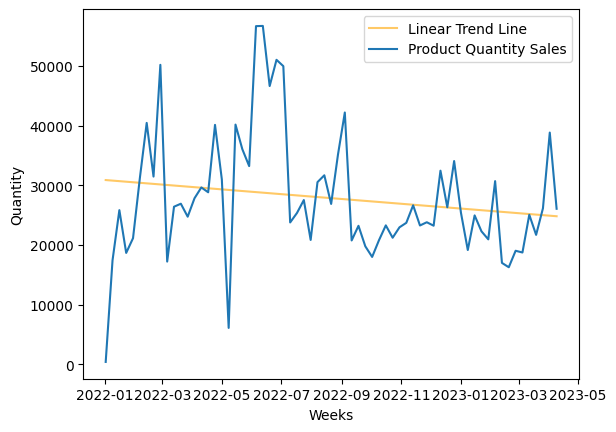

In [12]:
# visualisasi trend produk
m, b = np.polyfit(range(len(df_a1)), df_a1['quantity'], 1)
plt.plot(df_a1.index, m*range(len(df_a1)) + b, label='Linear Trend Line',color='orange', alpha=0.6)
plt.plot(df_a1.index, df_a1['quantity'], label='Product Quantity Sales')
plt.xlabel('Weeks')
plt.ylabel('Quantity')
plt.legend()
plt.show()

- Dilhat dari garisnya, trend untuk penjualan produk A ini mengalami penuruan

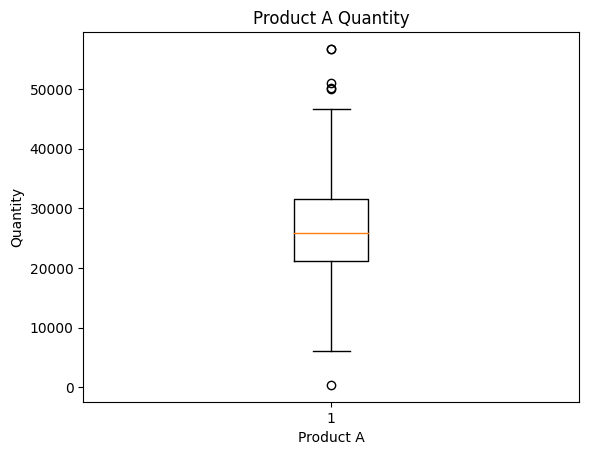

In [13]:
# check oulier pada quantity produk
plt.boxplot(df_a1['quantity'])
plt.xlabel('Product A')
plt.ylabel('Quantity')
plt.title('Product A Quantity')
plt.show()

- Sebelum melakukan forecast kita lihat dulu nilai ekstrim yang ada pada quantity data penjualan, lingkaran-lingkaran itu adalah outlier/data yang ekstrem, sebelum diproses ke model sebaiknya di tangani dulu outluer tersebut, disini saya menggunakan capping untuk mengatasi nilai ekstrem tersebut

In [14]:
# mengatasi outlier pada produk
Q1 = df_a1['quantity'].quantile(0.25)
Q3 = df_a1['quantity'].quantile(0.75)
IQR = Q3 - Q1
upper_cap = Q3 + 1.5 * IQR
lower_cap = Q1 - 1.5 * IQR
df_a1.loc[df_a1['quantity'] > upper_cap, 'quantity'] = upper_cap
df_a1.loc[df_a1['quantity'] < lower_cap, 'quantity'] = lower_cap

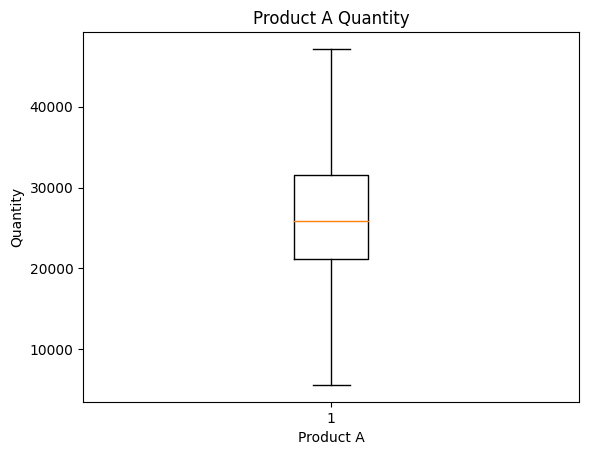

In [15]:
# check kembali oulier pada quantity produk
plt.boxplot(df_a1['quantity'])
plt.xlabel('Product A')
plt.ylabel('Quantity')
plt.title('Product A Quantity')
plt.show()

- Setelah diatasi outliernya cek kembali data, karena sudah tidak ada linglaran-lingkaran pada grafik, maka outlier suda teratasi dan data siap untuk di masukkan ke dalam model. Namunn sebelum itu mari kita cek dulu apakah data sudah stasioner atau belum pada proses di bawah ini

ADF Statistic: -9.012559
p-value: 0.000000
Critical Values:
	1%: -3.535
	5%: -2.907
	10%: -2.591
The time series is stationary.


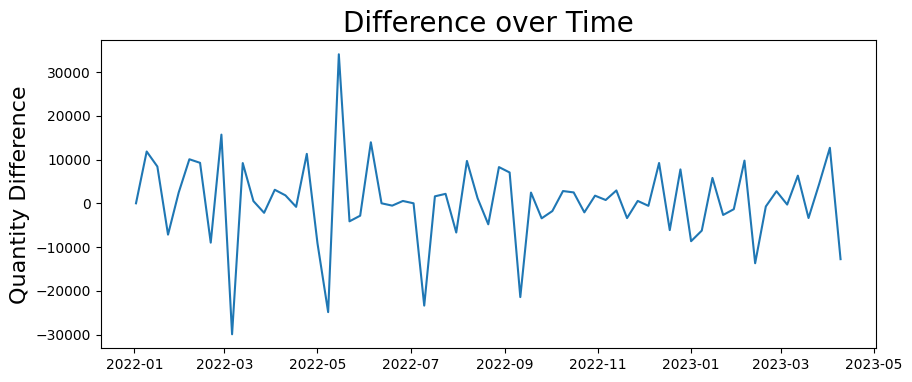

In [16]:
# mengecek dan menstasionerkan data dengan differencing

ts1 = df_a1['quantity']
fd_ts1 = ts1.diff(1).fillna(0)

result = adfuller(fd_ts1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[1] > 0.05:
    print('The time series is non-stationary.')
else:
    print('The time series is stationary.')

plt.figure(figsize=(10,4))
plt.plot(fd_ts1)
plt.title('Difference over Time', fontsize=20)
plt.ylabel('Quantity Difference', fontsize=16)
plt.show()

- Hasil dari poses diatas data sudah stasioner dengan 1 kali differenscing

Mengecek autoregressive and moving average untuk Produk A

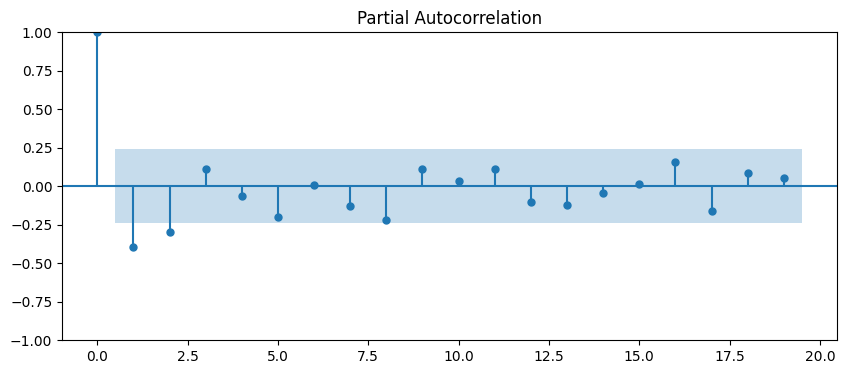

In [17]:
fig, ax = plt.subplots(figsize=(10, 4))
pacf_plot = plot_pacf(fd_ts1,ax=ax,method='ywm')

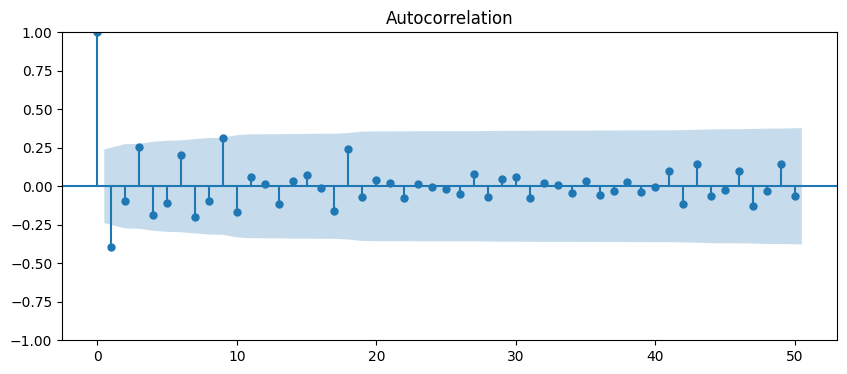

In [18]:
fig, ax = plt.subplots(figsize=(10, 4))
acf_plot = plot_acf(fd_ts1, lags=50,ax=ax)

- Kedua chart diatas dibuat untuk dianalisa dan hasil analisa dari sini akan digunakan sebagai paramter model

In [19]:
# membuat salinan data
data_a1 = df_a1.copy()

# mengatur index ke range of integers
data_a1.index = range(len(data_a1))

# memisah data_a1 ke train and test sets
train_a1 = data_a1['quantity'].iloc[:55]
test_a1 = data_a1['quantity'].iloc[55:]

# membuat dan fit model SARIMAX
model_a1 = SARIMAX(train_a1, order=(2, 1, 1), seasonal_order=(2,1,1,8))
model_fit_a1 = model_a1.fit()

MAPE : 0.18642565949414802
MAE : 4873.924528237405


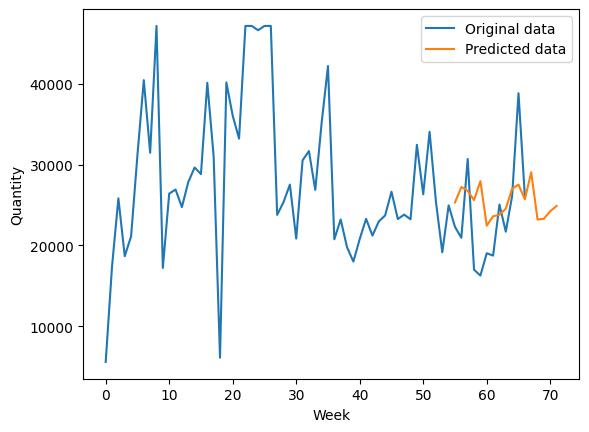

In [20]:
# membuat prediksi untuk data test dan forecast
predictions_a1 = model_fit_a1.forecast(steps=len(test_a1)+5)

# mengevaluasi performa model dengan (MAPE & MAE)
mape_a1 = mean_absolute_percentage_error(predictions_a1[:12],test_a1)
mae_a1 = mean_absolute_error(predictions_a1[:12],test_a1)
print(f'MAPE : {mape_a1}')
print(f'MAE : {mae_a1}')

# visualisasi hasil prediksi dan forecast
plt.plot(data_a1.index, data_a1['quantity'], label='Original data')
plt.plot(predictions_a1.index, predictions_a1, label='Predicted data')
plt.legend()
plt.xlabel('Week')
plt.ylabel('Quantity')
plt.show()

- Dalam memprediksi produk A saya menggunakan SARIMA, model dapat membuat prediksi, namun pada MAPE atau Mean Absolute Percentage Erornya cukup tinggi, dimana erornya 18,6%, serta quantity erornya atau selisih quantity hasil prediksi dengan data aslinya adalah 4873, ini tentu cukup buruk untuk sebuah model dalam memprediksi, namun saya sudah mencoba membuatnya sebaik mungkin tapi masih saja hasilnya kurang baggus, saya mengira ini karena datanya yang mingguan, dan sulit untuk mencari seasonalnya

## Produk B

Disini saya mwncoba untuk membat forecast dengan produk lain, dimisalkan adalah produk B, langkah langkahnya sama seperti pada Produk A, dimana menampilkan data asli, mengecek outlier pada quantity Produk B, mengatasi outlier, cek stasioner dan diferencing, cek plot ACF dan PACF untuk menentukan parameter lalu membuat model

In [21]:
# mengambil salah satu produk pada dataset
df_a2 = filtered_data[filtered_data['product_item']=='019502f6d13e383caa9b9673bf1302f8']

# set weeks sebagai index
df_a2 = df_a2.set_index('week_end_date')

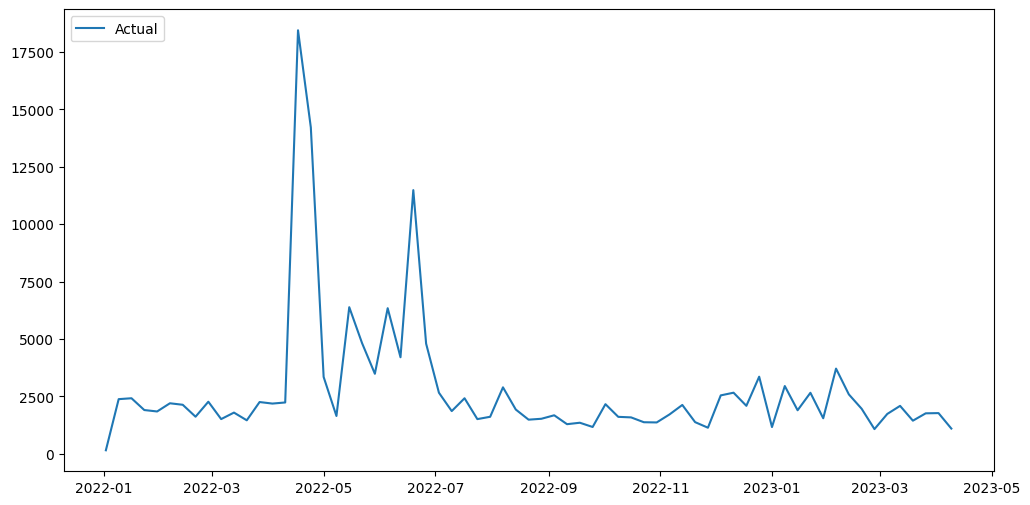

In [22]:
#menampilkan visualisasi penjualan produk
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_a2.index, df_a2['quantity'], label='Actual')
ax.legend(loc='upper left')
plt.show()

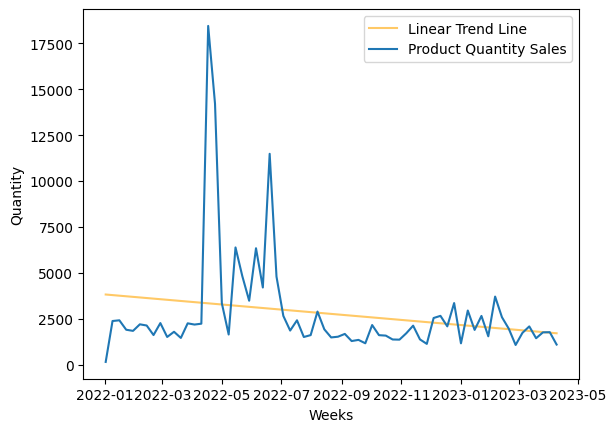

In [23]:
# visualisasi trend produk
m, b = np.polyfit(range(len(df_a2)), df_a2['quantity'], 1)
plt.plot(df_a2.index, m*range(len(df_a2)) + b, label='Linear Trend Line',color='orange', alpha=0.6)

plt.plot(df_a2.index, df_a2['quantity'], label='Product Quantity Sales')

plt.xlabel('Weeks')
plt.ylabel('Quantity')
plt.legend()

# show plot
plt.show()

- Linier trend sari Produk B adalah menurun

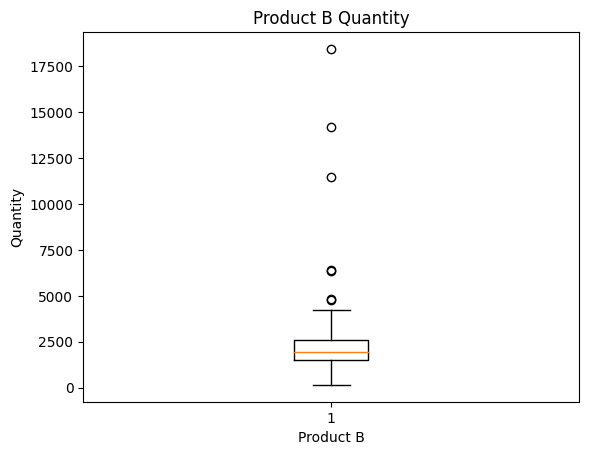

In [24]:
# check oulier pada quantity produk
plt.boxplot(df_a2['quantity'])
plt.xlabel('Product B')
plt.ylabel('Quantity')
plt.title('Product B Quantity')
plt.show()

- Terdapat outlier pada kolom quntity Produk B

In [25]:
# mengatasi outlier pada produk

Q1 = df_a2['quantity'].quantile(0.25)
Q3 = df_a2['quantity'].quantile(0.75)
IQR = Q3 - Q1
upper_cap = Q3 + 1.5 * IQR
lower_cap = Q1 - 1.5 * IQR
df_a2.loc[df_a2['quantity'] > upper_cap, 'quantity'] = upper_cap
df_a2.loc[df_a2['quantity'] < lower_cap, 'quantity'] = lower_cap

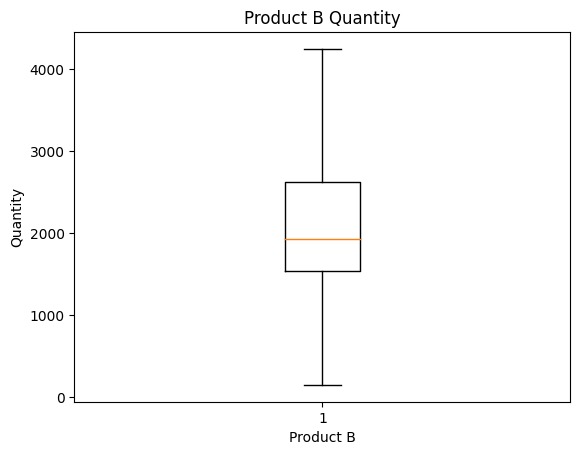

In [26]:
# check kembali oulier pada quantity produk
plt.boxplot(df_a2['quantity'])
plt.xlabel('Product B')
plt.ylabel('Quantity')
plt.title('Product B Quantity')
plt.show()

- Quantity produk B sudah bersih dari outlier

ADF Statistic: -7.560175
p-value: 0.000000
Critical Values:
	1%: -3.537
	5%: -2.908
	10%: -2.591
The time series is stationary.


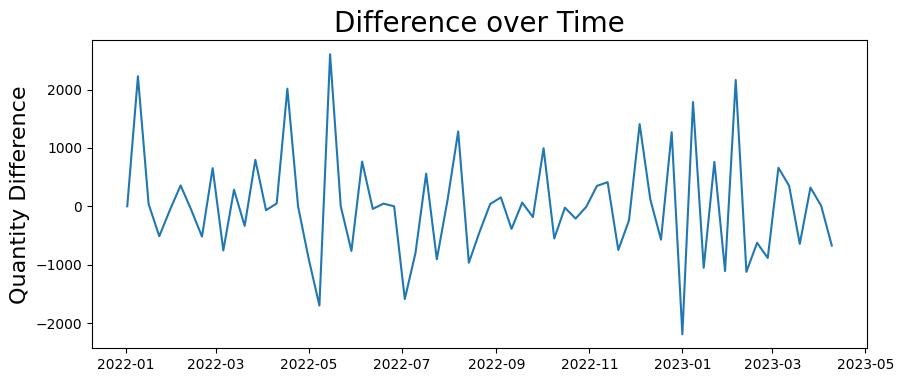

In [27]:
# mengecek dan menstasionerkan data dengan differencing

ts2 = df_a2['quantity']
fd_ts2 = ts2.diff().fillna(0)

result = adfuller(fd_ts2)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[1] > 0.05:
    print('The time series is non-stationary.')
else:
    print('The time series is stationary.')

plt.figure(figsize=(10,4))
plt.plot(fd_ts2)
plt.title('Difference over Time', fontsize=20)
plt.ylabel('Quantity Difference', fontsize=16)
plt.show()

- Setelah di diferencing 1x data sudah stasioner

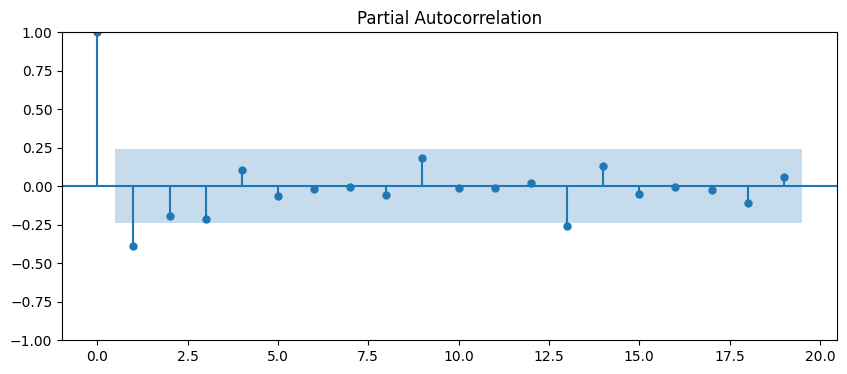

In [28]:
fig, ax = plt.subplots(figsize=(10, 4))
pacf_plot = plot_pacf(fd_ts2,ax=ax,method='ywm')

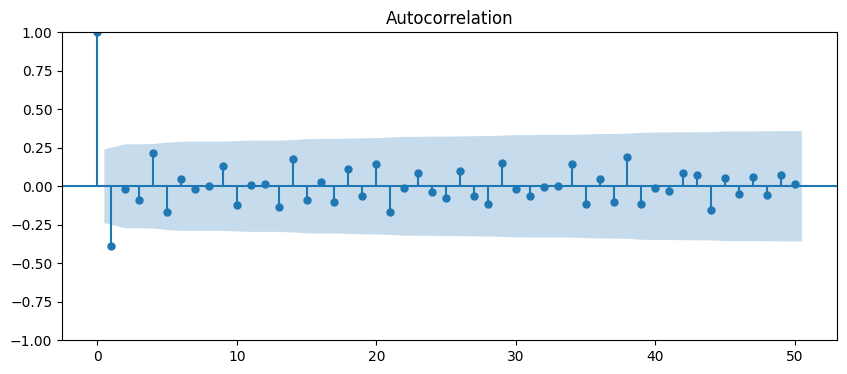

In [29]:
fig, ax = plt.subplots(figsize=(10, 4))
acf_plot = plot_acf(fd_ts2, lags=50,ax=ax)

- pacf dan acf cut off di 1 maka ini akan digunakan ke dalam model SARIMA nantinya sebagai order

In [30]:
# membuat salinan data
data_a2 = df_a2.copy()

# mengatur index ke range of integers
data_a2.index = range(len(data_a2))

# memisah data_a1 ke train and test sets
train_a2 = data_a2['quantity'].iloc[:55]
test_a2 = data_a2['quantity'].iloc[55:]

# membuat dan fit model SARIMAX
model_a2 = SARIMAX(train_a2, order=(1, 1, 1), seasonal_order=(1,1,1,13))
model_fit_a2 = model_a2.fit()

MAPE : 0.2605498071074704
MAE : 507.90789175778224


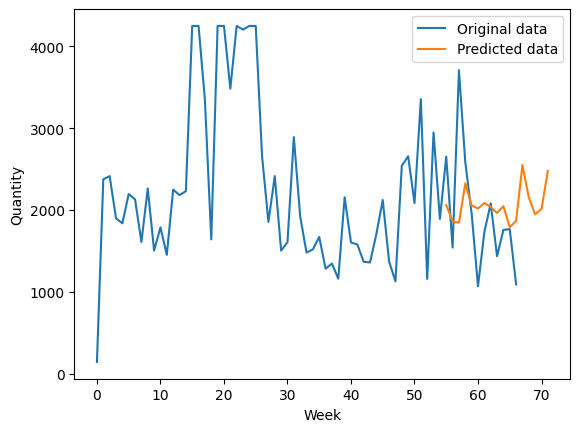

In [31]:
# membuat prediksi untuk data test dan forecast
predictions_a2 = model_fit_a2.forecast(steps=len(test_a2)+5)

# mengevaluasi performa model dengan (MAPE & MAE)
mape_a2 = mean_absolute_percentage_error(predictions_a2[:12],test_a2)
mae_a2 = mean_absolute_error(predictions_a2[:12],test_a2)
print(f'MAPE : {mape_a2}')
print(f'MAE : {mae_a2}')

# visualisasi hasil prediksi dan forecast
plt.plot(data_a2.index, data_a2['quantity'], label='Original data')
plt.plot(predictions_a2.index, predictions_a2, label='Predicted data')
plt.legend()
plt.xlabel('Week')
plt.ylabel('Quantity')
plt.show()

- Dlam memprediksi quntity yang terjual pada produk B, disini saya masih menggunakan model SARIMA, kendalanya masih sama dengan Produk A dimana saya kesulitan menemukan seasonalitasnya, dan alhasil model underfit, dimana presentase erornya diatas 26% , cukup tinggi, berbahaya jik digunakan dalam konteks bisnis, prediksinya cuan tapi ternyata realitanya tidak

## Produk C

Disini saya akan mencoba 1 model lagi untuk membuat prediksi quntitynya, dimisalkan ini adalah produk C

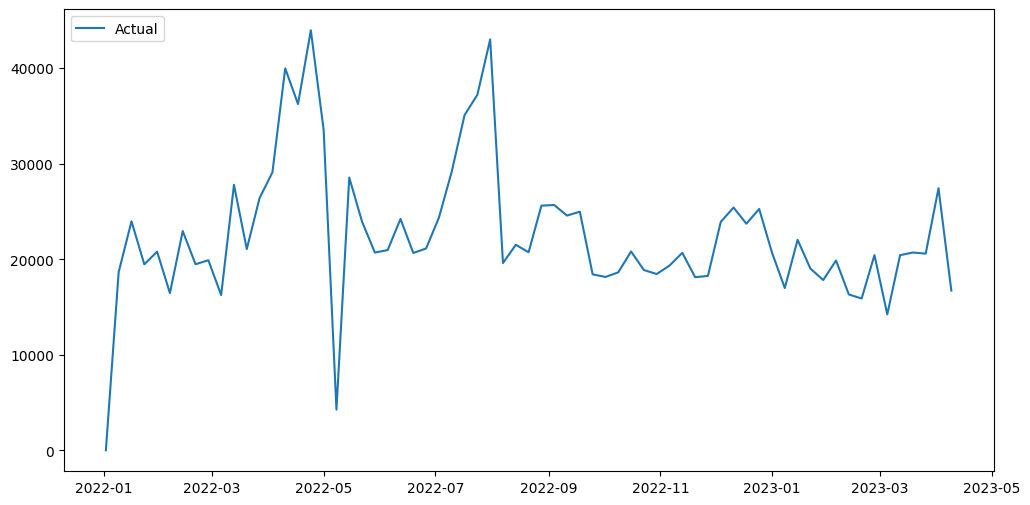

In [32]:
# mengambil salah satu produk pada dataset
df_a3 = filtered_data[filtered_data['product_item']=='6504277ce7b2db047fd013d3fd979253']

# set weeks sebagai index
df_a3 = df_a3.set_index('week_end_date')

#menampilkan visualisasi penjualan produk
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_a3.index, df_a3['quantity'], label='Actual')
ax.legend(loc='upper left')
plt.show()

- Dilihat pada chart sepertinya ini tidak ada seasonal nya, pola berantakan dan terkadang naik dan turun secara drastis

In [43]:
df_a6 = df_a3

In [44]:
df_a6

,week_number,week_start_date,product_item,quantity,weeks
week_end_date,,,,,
2022-01-02,2021-52,2021-12-27,6504277ce7b2db047fd013d3fd979253,9227.5,1
2022-01-09,2022-01,2022-01-03,6504277ce7b2db047fd013d3fd979253,18662.0,2
2022-01-16,2022-02,2022-01-10,6504277ce7b2db047fd013d3fd979253,23977.0,3
2022-01-23,2022-03,2022-01-17,6504277ce7b2db047fd013d3fd979253,19475.0,4
2022-01-30,2022-04,2022-01-24,6504277ce7b2db047fd013d3fd979253,20800.0,5
...,...,...,...,...,...
2023-03-12,2023-10,2023-03-06,6504277ce7b2db047fd013d3fd979253,20432.0,63
2023-03-19,2023-11,2023-03-13,6504277ce7b2db047fd013d3fd979253,20710.0,64
2023-03-26,2023-12,2023-03-20,6504277ce7b2db047fd013d3fd979253,20596.0,65


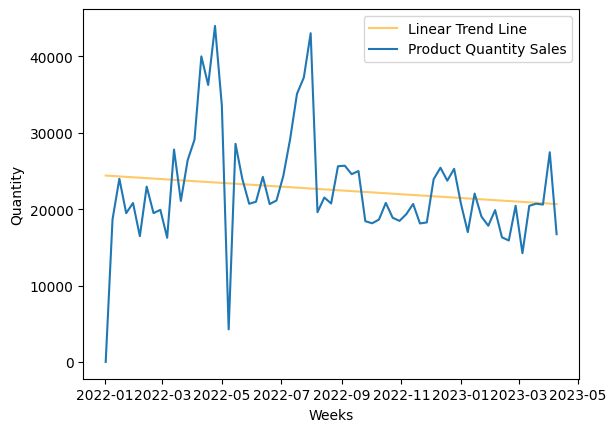

In [33]:
# visualisasi trend produk
m, b = np.polyfit(range(len(df_a3)), df_a3['quantity'], 1)
plt.plot(df_a3.index, m*range(len(df_a3)) + b, label='Linear Trend Line',color='orange', alpha=0.6)
plt.plot(df_a3.index, df_a3['quantity'], label='Product Quantity Sales')
plt.xlabel('Weeks')
plt.ylabel('Quantity')
plt.legend()
plt.show()

- Trend Produk C selama periode ini adalah negatif atau menurun

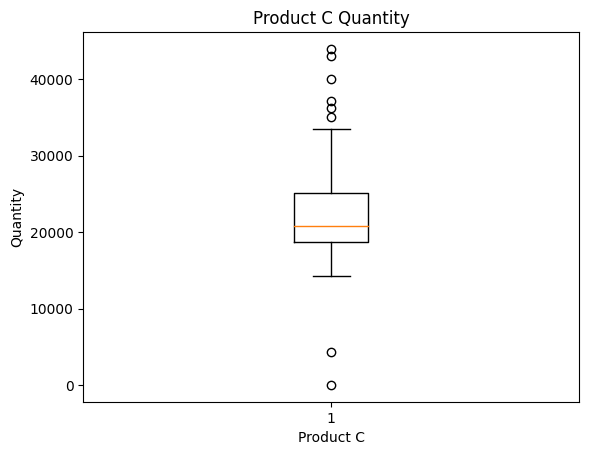

In [34]:
# check oulier pada quantity produk
plt.boxplot(df_a3['quantity'])
plt.xlabel('Product C')
plt.ylabel('Quantity')
plt.title('Product C Quantity')
plt.show()

L- Cukup banyak outlier pada Produk C ini, jadi saaya akan mengatasi outlier tersebut dengan menggunakan capping, data yag nilainya ekstrim akan di masukkan ke dalam batas atas maupun bawah

In [35]:
# mengatasi outlier pada produk
Q1 = df_a3['quantity'].quantile(0.25)
Q3 = df_a3['quantity'].quantile(0.75)
IQR = Q3 - Q1
upper_cap = Q3 + 1.5 * IQR
lower_cap = Q1 - 1.5 * IQR
df_a3.loc[df_a3['quantity'] > upper_cap, 'quantity'] = upper_cap
df_a3.loc[df_a3['quantity'] < lower_cap, 'quantity'] = lower_cap

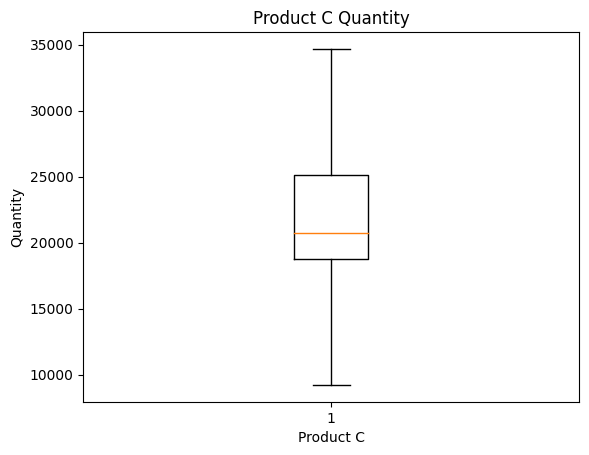

In [36]:
# checkkembali oulier pada quantity produk
plt.boxplot(df_a3['quantity'])
plt.xlabel('Product C')
plt.ylabel('Quantity')
plt.title('Product C Quantity')
plt.show()

- Produk C sudah bersih dari outlier dan siap untuk digunakan sebagai input model

ADF Statistic: -11.862853
p-value: 0.000000
Critical Values:
	1%: -3.534
	5%: -2.906
	10%: -2.591
The time series is stationary.


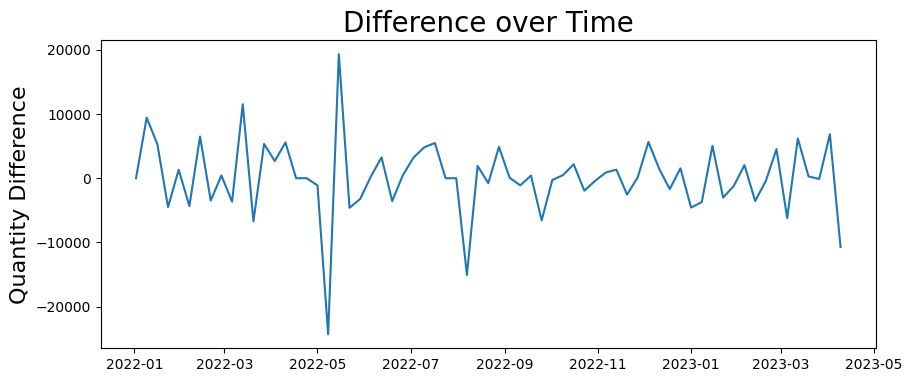

In [37]:
# mengecek dan menstasionerkan data dengan differencing

ts3 = df_a3['quantity']
fd_ts3 = ts3.diff(1).fillna(0)

result = adfuller(fd_ts3)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[1] > 0.05:
    print('The time series is non-stationary.')
else:
    print('The time series is stationary.')

plt.figure(figsize=(10,4))
plt.plot(fd_ts3)
plt.title('Difference over Time', fontsize=20)
plt.ylabel('Quantity Difference', fontsize=16)
plt.show()

- Dari hasil pengecekan data sudah stasioner setelah di diferencing 1x

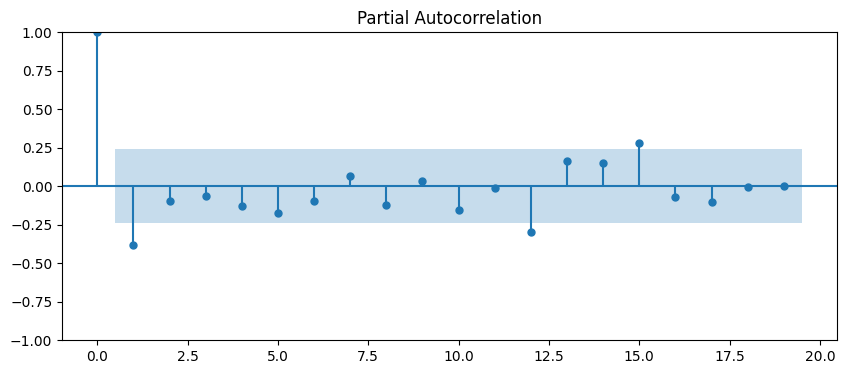

In [38]:
fig, ax = plt.subplots(figsize=(10, 4))
pacf_plot = plot_pacf(fd_ts3,ax=ax,method='ywm')

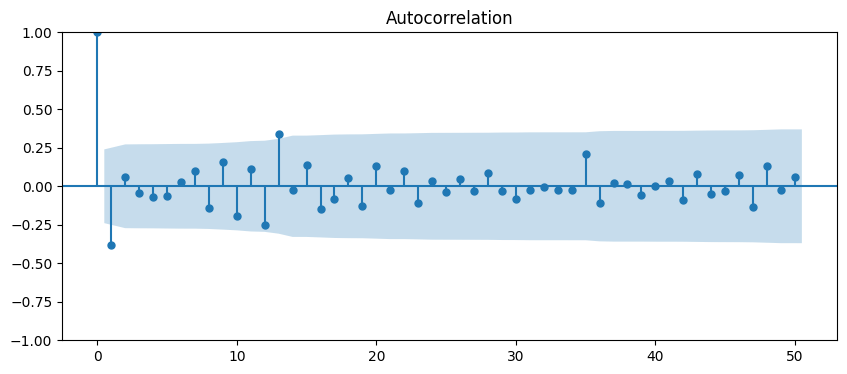

In [39]:
fig, ax = plt.subplots(figsize=(10, 4))
acf_plot = plot_acf(fd_ts3, lags=50,ax=ax)

- ACF dan PACF juga cut off di 1, ditunjukan dengan Partial Autocorrelationya yang setelah langkah ke 1 gambar yang ada bulatannya langsunng masuk diantara blok biru, jadi dikatakan cut off di 1

In [40]:
# membuat salinan data
data_a3 = df_a3.copy()

# mengatur index ke range of integers
data_a3.index = range(len(data_a3))

# memisah data_a1 ke train and test sets
train_a3 = data_a3['quantity'].iloc[:55]
test_a3 = data_a3['quantity'].iloc[55:]

# membuat dan fit model SARIMAX
model_a3 = SARIMAX(train_a3, order=(1, 1, 1), seasonal_order=(1,1,1,8))
model_fit_a3 = model_a3.fit()

- Hasil PCAF dan ACF tadi digunakan pada order di dalam model fit, PCAF cut off 1 order = (1,0,0) dianjutkan dengan diferencing 1 menjadi order = (1,1,0), lalu untuk Autocoorelation cut off di 1 artinya order = (1,1,1)

MAPE : 0.14609695910213197
MAE : 3177.2099476240096


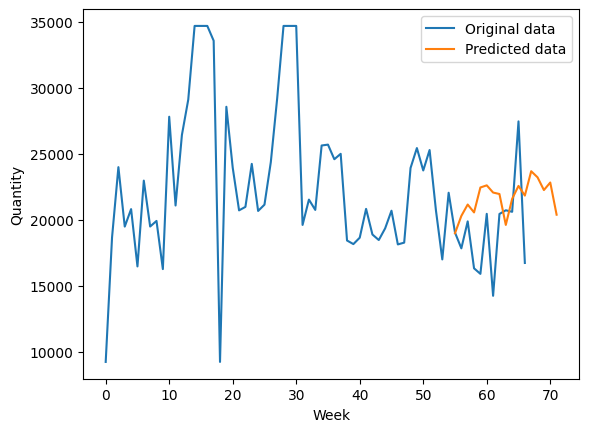

In [41]:
# membuat prediksi untuk data test dan forecast
predictions_a3 = model_fit_a3.forecast(steps=len(test_a3)+5)

# mengevaluasi performa model dengan (MAPE & MAE)
mape_a3 = mean_absolute_percentage_error(predictions_a3[:12],test_a3)
mae_a3 = mean_absolute_error(predictions_a3[:12],test_a3)
print(f'MAPE : {mape_a3}')
print(f'MAE : {mae_a3}')

# visualisasi hasil prediksi dan forecast
plt.plot(data_a3.index, data_a3['quantity'], label='Original data')
plt.plot(predictions_a3.index, predictions_a3, label='Predicted data')
plt.legend()
plt.xlabel('Week')
plt.ylabel('Quantity')
plt.show()

-  Dalam produk C erornya masih cukup tinggi yaitu 14% tapi ini performa model SARIMA lebih baik digunakan pada produk C ini, berbeda dengan SARIMA yang di pakai pada Produk A dan B, disini menunjukan bahwa model itu bisa dikatakan cocok cocokan unntuk membuat prediksi, misal dengan model yang sama untuk 3 produk hasilnya berbeda beda, ini membuktikan asumsi saya bahwa untuk membuat forecast idelanya harus di breakdown tiap produknya, di buatkan parameter yang sesuai dengan karakteristik produk.  Tidak bisa di generalisir satu model dengan paramter umum digunakan untuk memprediksi semua produk, tentu hasilnya akan kurang maksimal dan kurang baik.

# Kesimpulan

Dalam permasalahan kali ini dimana untuk membuat foracest, saya mengalami kesulitan, dimana untuk akurasi model saya banyak yang kurang akurat, erornya masih tinggi, kebanyakan diatas 20%, tentu ini akan tidak baik jika model yang saya buat di impelemntasikan ke dalam domain bisnis, maka model yang saya buat masih perlu banyak improvement terutama di data proprosesingnya, dimana saya mengalamii kesulitan disitu, sulit menemukan seasonalitas pada data yang tersedia dan keterbatasan ilmu pengetahuan saya untuk mengolahnya. Untuk membuat forecast idealnya adalah membuat model tersendiri untuk setiap produk, karena produk memiliki karakteristik sendiri-sendiri, trendnya tidak sama untuk setiap produk, sesaonalitas juga beda beda, jadi untuk membuat model dengan banyak produk saya mengalami kesulitan dan keterbatasn waktu, dimana saya sudah mencoba membuat model untuk banyak produk tapi hasilnya kurang bagus, erornya sangat tinggi, dicoba dengan perproduk ada peningkatan pada hasil forecast di bandingkan dengan satu model untuk membuat semua forecast produk.